# Use the markers across the wall to see if the disparity is same as the edges

In [1]:
import numpy as np
import depthai as dai
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

In [147]:
aruco_dictionary = aruco.Dictionary_get(aruco.DICT_4X4_1000)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.00001)

def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    plt.figure(figsize=(12, 8))
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.imshow(image)


def display_overlay_points(left_pts, right_pts, markerSize = 20, setSize = True):
    plt.figure(figsize=(12, 8))
    plt.rcParams["figure.autolayout"] = True
    if setSize:
        plt.xlim(0, size[0])
        plt.ylim(0, size[1])
    plt.grid()

    x = left_pts[0, :, 0]
    y = left_pts[0, :, 1]
    color = "blue"
    plt.scatter(x, y, c=color, s = markerSize)

    x = right_pts[0, :, 0]
    y = right_pts[0, :, 1]
    color = "red"
    plt.scatter(x, y, c=color, s = markerSize)


    # ?plt.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
    plt.show()

def detectMarkers(image_rgb):
    image = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
    marker_corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, aruco_dictionary)
    # print(f'Shape of markers corners => {(rejectedImgPoints)}')
    
    marker_corners_list = []
    for marker in marker_corners:
        marker_corners_list.append(marker[-1])
    marker_corners_list = np.asarray(marker_corners_list).reshape(-1, 2)
    cv2.cornerSubPix(image, marker_corners_list, (3,3), (-1,-1), criteria)
    return marker_corners_list, ids

def display_overlay_points(left_pts, right_pts, markerSize = 20):
    plt.figure(figsize=(12, 8))
    plt.rcParams["figure.autolayout"] = True
    plt.xlim(0, size[0])
    plt.ylim(0, size[1])
    plt.grid()

    x = left_pts[0, :, 0]
    y = left_pts[0, :, 1]
    color = "blue"
    plt.scatter(x, y, c=color, s = markerSize)

    x = right_pts[0, :, 0]
    y = right_pts[0, :, 1]
    color = "red"
    plt.scatter(x, y, c=color, s = markerSize)


    # ?plt.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
    plt.show()

In [181]:
size = (1920, 1200)

calibration_handler = dai.CalibrationHandler('./calib_sensor_07.json')
M_left = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoLeftCameraId(), size[0], size[1]))
M_right = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoRightCameraId(), size[0], size[1]))
D_left = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoLeftCameraId()))
D_right = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoRightCameraId()))

transform = np.array(calibration_handler.getCameraExtrinsics(calibration_handler.getStereoRightCameraId(), calibration_handler.getStereoLeftCameraId())) 

left_rot_right = transform[:3, :3]
left_t_right = transform[:3, 3]
# Left is basically the origin here so
origin_rot_right = left_rot_right
origin_t_right = left_t_right
origin_rot_left = np.eye(3, dtype = np.float32)

R1 = np.array(calibration_handler.getStereoLeftRectificationRotation())
R2 = np.array(calibration_handler.getStereoRightRectificationRotation())

if 0:
    roll = 0
    pitch = 20 
    yaw = 0
    left_translation = np.array([5.0, 0.0, 0.0])
    rot_euler = R.from_euler('XYZ', [roll, pitch, yaw], degrees=True)
    cam_rot_matrix = rot_euler.as_matrix()
    
    rotation_matrix_4x4 = np.eye(4)
    rotation_matrix_4x4[:3, :3] = cam_rot_matrix
    rotation_matrix_4x4[0, 3] = left_translation[0]
    rotated_se3_matrix = transform @ rotation_matrix_4x4

    # Left is basically the origin here but rotated 20 deg. 
    origin_rot_right = rotated_se3_matrix[:3, :3]
    origin_t_right = rotated_se3_matrix[:3, 3]
    origin_rot_left = cam_rot_matrix
    
    origin_rvec_left, _ = cv2.Rodrigues(origin_rot_left)
    origin_rvec_right, _ = cv2.Rodrigues(origin_rot_right)
else:
    left_translation = np.array([0.0, 0.0, 0.0])

    origin_rvec_left, _ = cv2.Rodrigues(origin_rot_left)
    origin_rvec_right, _ = cv2.Rodrigues(origin_rot_right)

    # transform
    


M_focal = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(M_right, D_right, size, np.eye(3), fov_scale=1.1)
mapXL, mapYL = cv2.fisheye.initUndistortRectifyMap(M_left, D_left[:4], R1, M_focal, size, cv2.CV_32FC1)
mapXR, mapYR = cv2.fisheye.initUndistortRectifyMap(M_right, D_right[:4], R2, M_focal, size, cv2.CV_32FC1)


(1200, 1920, 3)


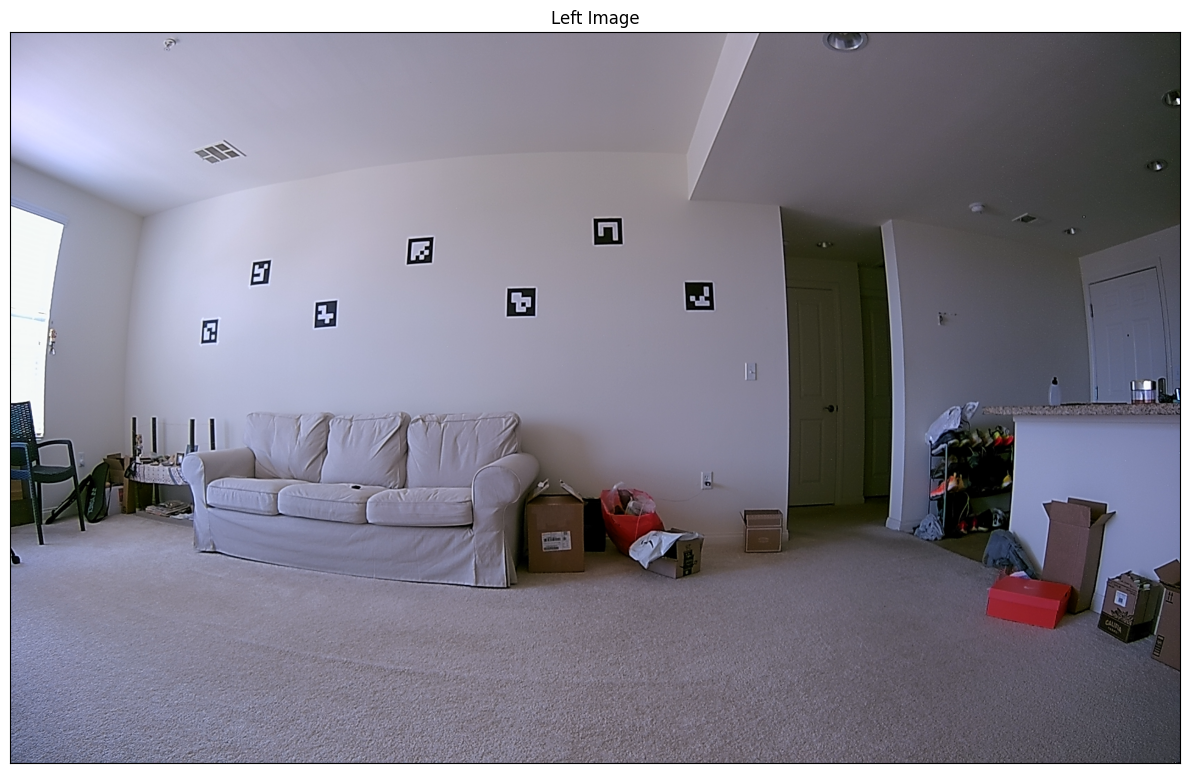

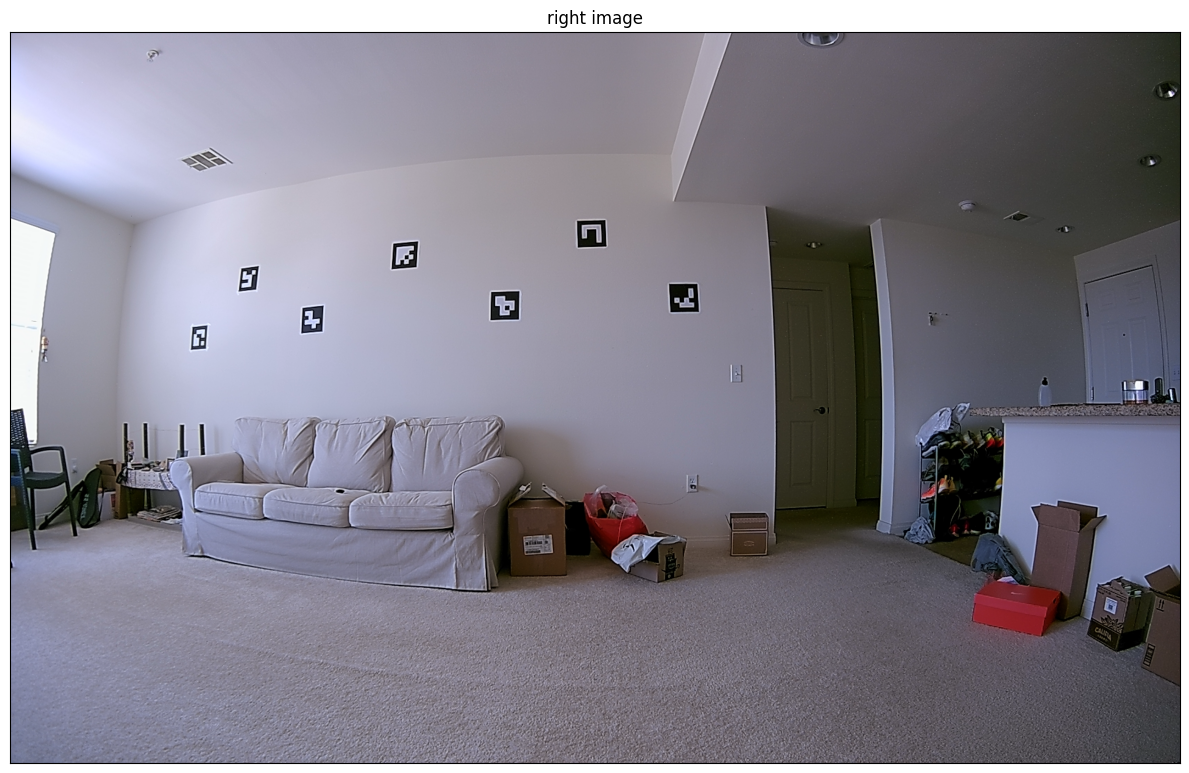

In [182]:
folder_name = 'dataset_07_aruco_16_may_3.47'
left_image = cv2.imread(folder_name + '/left/left_p0_0.png')
right_image = cv2.imread(folder_name + '/right/right_p0_0.png')
show_rgb_image(left_image, 'Left Image')
show_rgb_image(right_image, 'right image')
print(left_image.shape)

## Original markers

PS: position of the points in the plot would be inverted upside down relative to the image

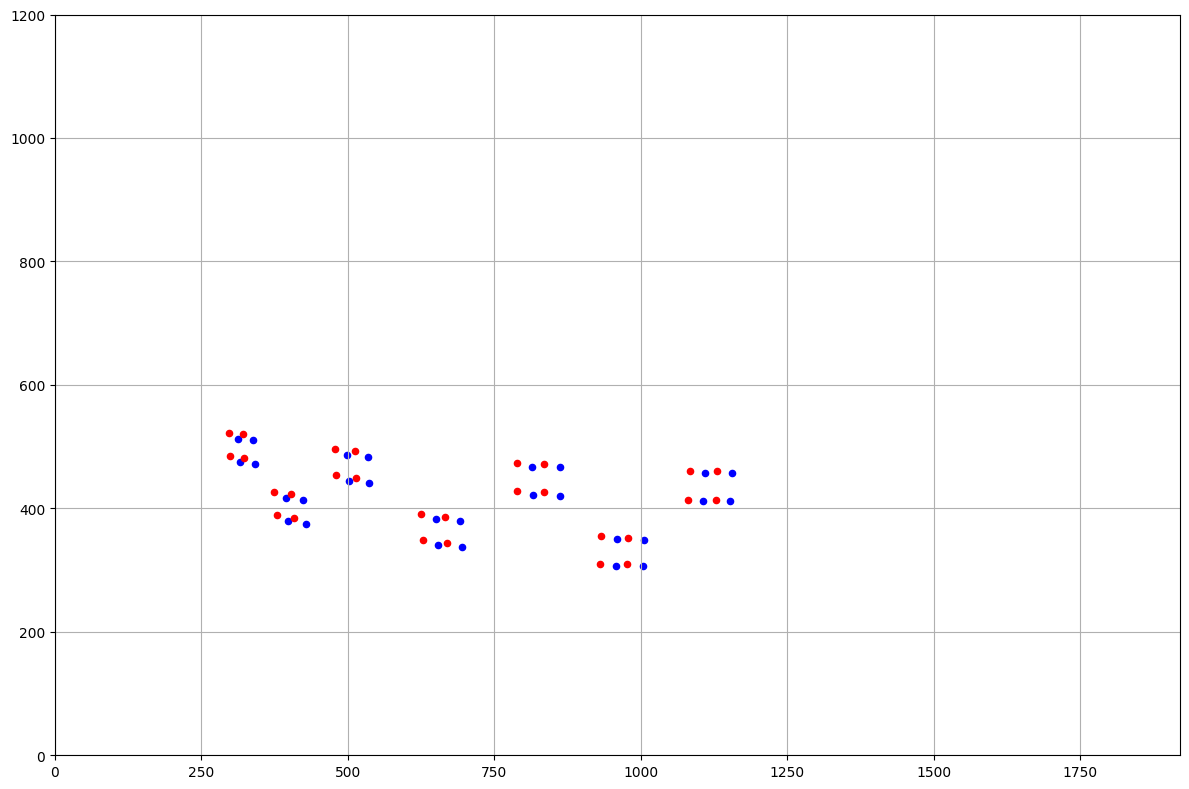

In [183]:
left_markers, left_ids = detectMarkers(left_image)
right_markers, right_ids = detectMarkers(right_image)
display_overlay_points(left_markers[None], right_markers[None])

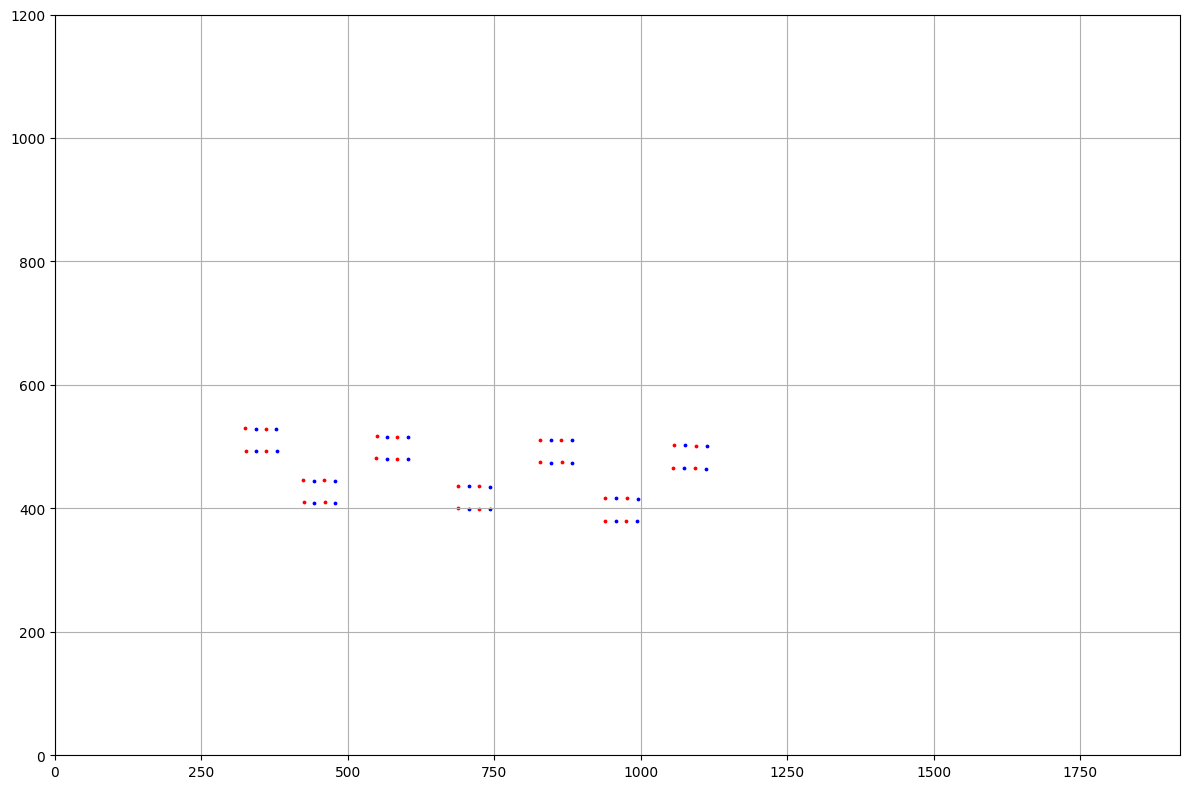

In [184]:
left_rectify_points = cv2.fisheye.undistortPoints(left_markers[None], M_left, D_left, R = R1, P = M_focal)
right_rectify_points = cv2.fisheye.undistortPoints(right_markers[None], M_right, D_right, R = R2, P = M_focal)
display_overlay_points(left_rectify_points, right_rectify_points, 3)

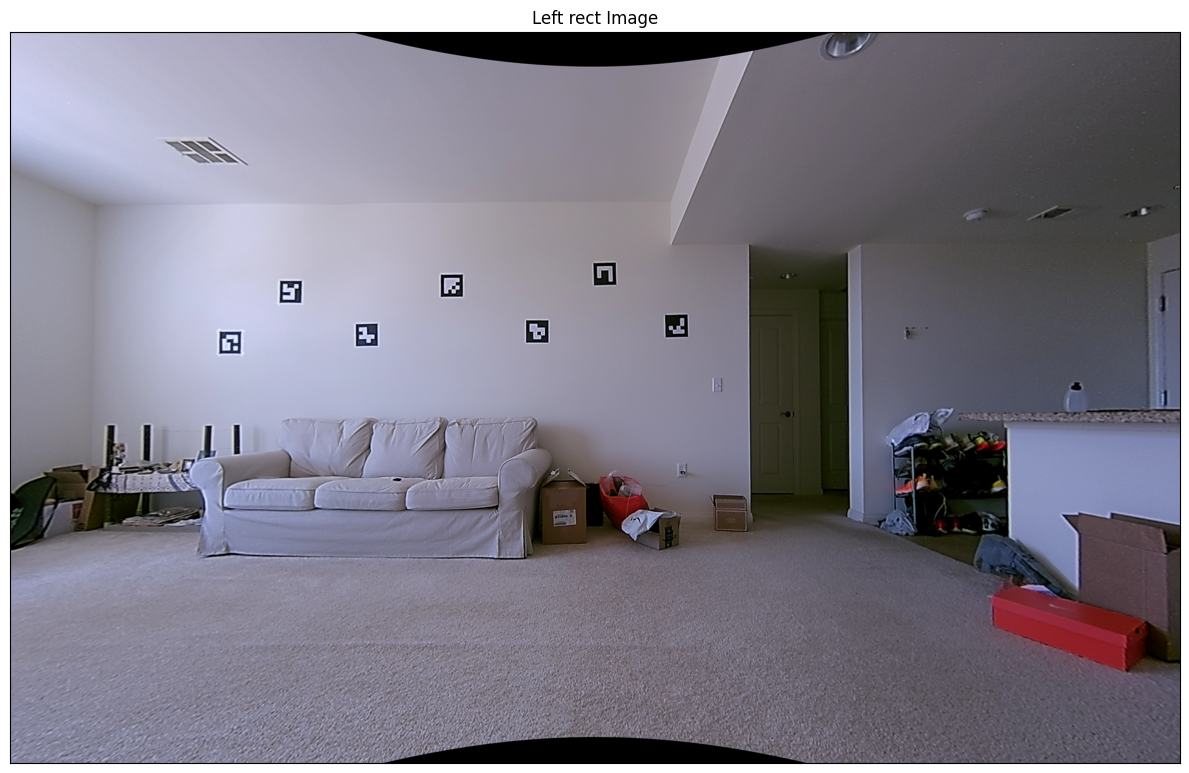

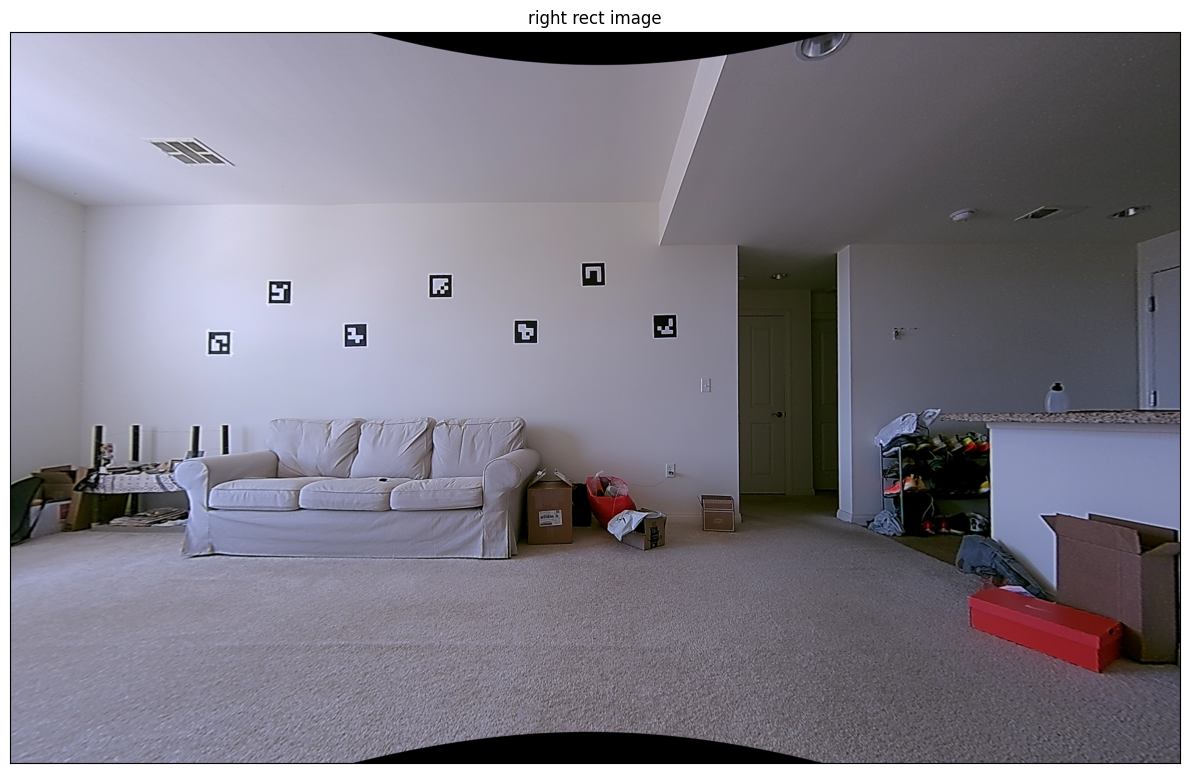

In [185]:
left_rect = cv2.remap(left_image , mapXL, mapYL, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
right_rect = cv2.remap(right_image, mapXR, mapYR, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
show_rgb_image(left_rect, 'Left rect Image')
show_rgb_image(right_rect, 'right rect image')

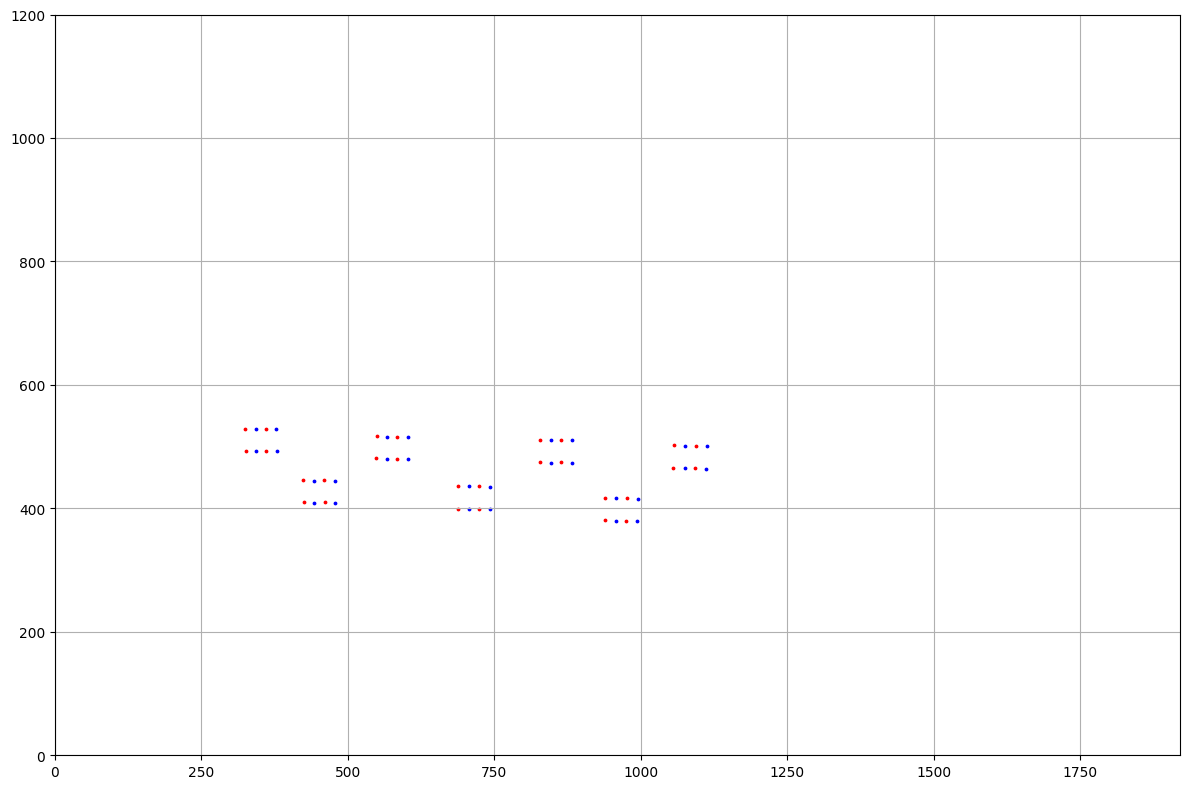

In [186]:
left_indirect_rectify_points, left_ids_indirect = detectMarkers(left_rect)
right_indirect_rectify_points, right_ids_indirect = detectMarkers(right_rect)
display_overlay_points(left_indirect_rectify_points[None], right_indirect_rectify_points[None], 3)

## Display all in 1

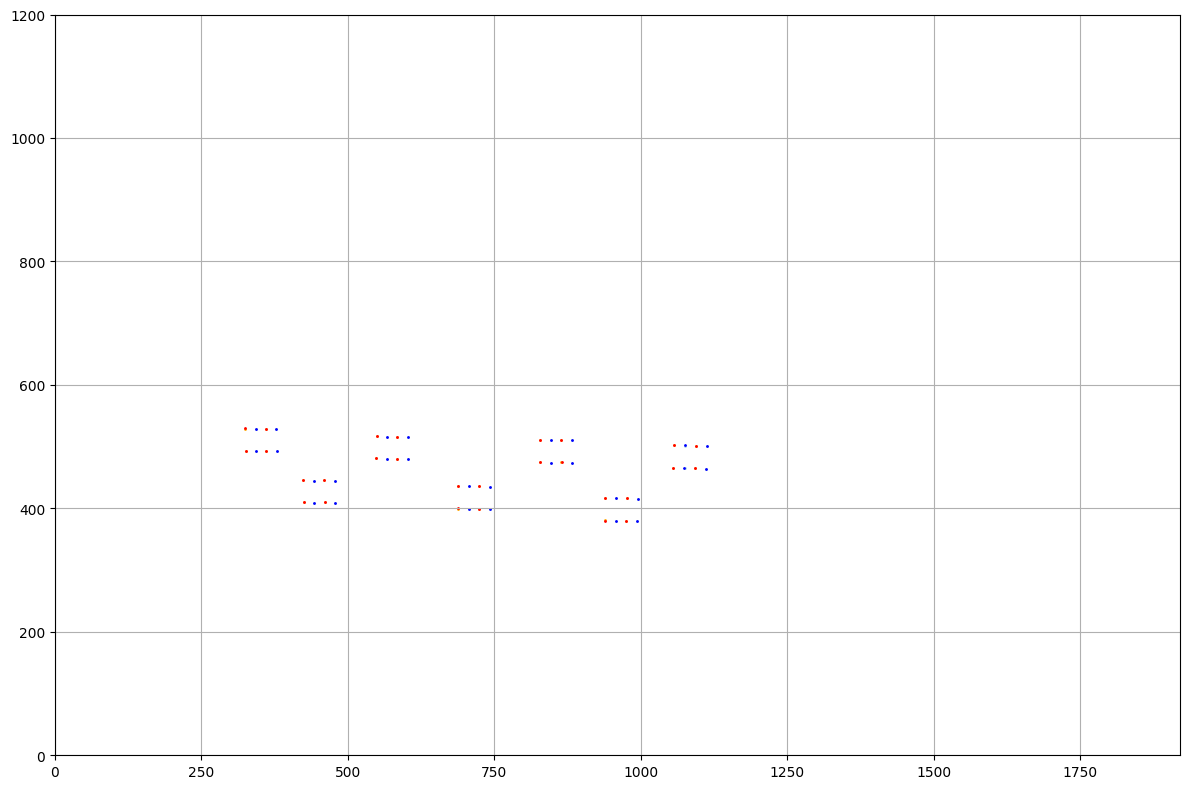

In [187]:
plt.figure(figsize=(12, 8))
plt.rcParams["figure.autolayout"] = True
plt.xlim(0, size[0])
plt.ylim(0, size[1])
plt.grid()

x = left_indirect_rectify_points[:, 0]
y = left_indirect_rectify_points[:, 1]
color = "lightblue"
plt.scatter(x, y, c=color, s = 1)

x = right_indirect_rectify_points[:, 0]
y = right_indirect_rectify_points[:, 1]
color = "orange"
plt.scatter(x, y, c=color, s = 1)

x = left_rectify_points[0, :, 0]
y = left_rectify_points[0, :, 1]
color = "blue"
plt.scatter(x, y, c=color, s = 1)

x = right_rectify_points[0, :, 0]
y = right_rectify_points[0, :, 1]
color = "red"
plt.scatter(x, y, c=color, s = 1)

plt.show()

In [200]:
z_distance_cm = 349

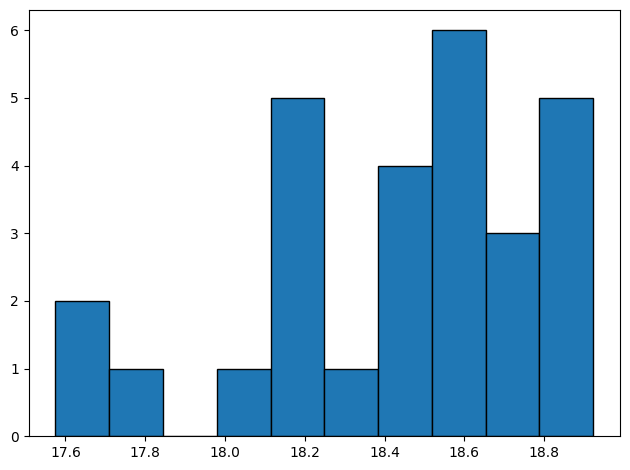

In [201]:
list_disparity_direct = []
list_disparity_indirect = []
for i in range(left_rectify_points.shape[1]):
    list_disparity_direct.append(left_rectify_points[0, i, 0] - right_rectify_points[0, i, 0])
    list_disparity_indirect.append(left_indirect_rectify_points[i, 0] - right_indirect_rectify_points[i, 0])

list_disparity_direct = np.array(list_disparity_direct)
list_disparity_indirect = np.array(list_disparity_indirect)
plt.hist(list_disparity_direct, bins=10, edgecolor='black')
plt.show()

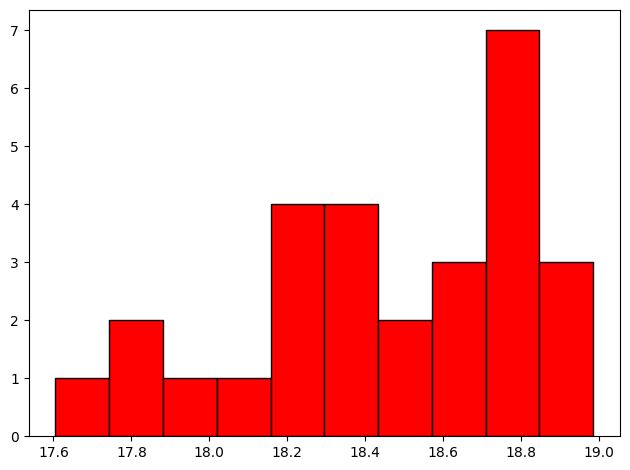

In [202]:
plt.hist(list_disparity_indirect, bins=10, edgecolor='black', color='red')
plt.show()

In [203]:
def dispDepthConverter(disparity): # Does Disparity to Depth or Depth to disparity. 
    return left_t_right[0] * M_focal[0][0] / disparity

print(f' depth at max disparity from the points projection is {dispDepthConverter(np.max(list_disparity_direct))}')
print(f' depth at min disparity from the points projection is {dispDepthConverter(np.min(list_disparity_direct))}')
print(f' depth at median disparity from the points projection is {dispDepthConverter(np.median(list_disparity_direct))}')
print(f'Accuracy at max disparity value of {list_disparity_direct.max()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity_direct.max())) / z_distance_cm) * 100}%')
print(f'Accuracy at Min disparity value of {list_disparity_direct.min()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity_direct.min())) / z_distance_cm) * 100}%')
print(f'Accuracy at median disparity value of {np.median(list_disparity_direct)} is  Value -> {((z_distance_cm - dispDepthConverter(np.median(list_disparity_direct))) / z_distance_cm) * 100}%')



 depth at max disparity from the points projection is 360.51376236961113
 depth at min disparity from the points projection is 388.1565061580156
 depth at median disparity from the points projection is 368.43552242748143
Accuracy at max disparity value of 18.92279052734375 is  Value -> -3.2990723122094923%
Accuracy at Min disparity value of 17.5751953125 is  Value -> -11.219629271637704%
Accuracy at median disparity value of 18.51593017578125 is  Value -> -5.568917600997544%


In [204]:
print(f' depth at max disparity from the points projection is {dispDepthConverter(np.max(list_disparity_indirect))}')
print(f' depth at min disparity from the points projection is {dispDepthConverter(np.min(list_disparity_indirect))}')
print(f' depth at median disparity from the points projection is {dispDepthConverter(np.median(list_disparity_indirect))}')
print(f'Accuracy at max disparity value of {list_disparity_indirect.max()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity_indirect.max())) / z_distance_cm) * 100}%')
print(f'Accuracy at Min disparity value of {list_disparity_indirect.min()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity_indirect.min())) / z_distance_cm) * 100}%')
print(f'Accuracy at median disparity value of {np.median(list_disparity_indirect)} is  Value -> {((z_distance_cm - dispDepthConverter(np.median(list_disparity_indirect))) / z_distance_cm) * 100}%')


 depth at max disparity from the points projection is 359.33734001148673
 depth at min disparity from the points projection is 387.49375446996874
 depth at median disparity from the points projection is 369.4890653263236
Accuracy at max disparity value of 18.9847412109375 is  Value -> -2.9619885419732754%
Accuracy at Min disparity value of 17.605255126953125 is  Value -> -11.029729074489609%
Accuracy at median disparity value of 18.463134765625 is  Value -> -5.870792357112783%


In [205]:
sorted_indices = np.argsort(left_rectify_points[0, :, 0])
# left_rectify_points[0, sorted_indices]
for i in sorted_indices:
    print(f' {left_rectify_points[0, i]} \t --direct--> {list_disparity_direct[i]:.2f} --indirect--{list_disparity_indirect[i]:.2f}')

 [342.99734 528.67126] 	 --direct--> 18.17 --indirect--18.26
 [343.44138 492.42633] 	 --direct--> 17.74 --indirect--17.80
 [377.97894 528.4758 ] 	 --direct--> 17.58 --indirect--17.61
 [379.05374 492.43314] 	 --direct--> 18.33 --indirect--18.33
 [441.87296 444.9345 ] 	 --direct--> 18.08 --indirect--18.02
 [442.89957 409.1967 ] 	 --direct--> 17.67 --indirect--17.76
 [477.46323 445.04767] 	 --direct--> 18.14 --indirect--18.19
 [478.38425 409.2402 ] 	 --direct--> 18.20 --indirect--18.14
 [567.2226  480.16397] 	 --direct--> 18.49 --indirect--18.46
 [567.3906 516.3835] 	 --direct--> 18.41 --indirect--18.47
 [602.81744 479.4528 ] 	 --direct--> 18.21 --indirect--18.29
 [602.89886 515.4576 ] 	 --direct--> 18.18 --indirect--18.23
 [706.44257 435.43634] 	 --direct--> 18.62 --indirect--18.72
 [706.653   399.17624] 	 --direct--> 18.64 --indirect--18.60
 [742.5917  434.95047] 	 --direct--> 18.45 --indirect--18.30
 [742.87134 398.77893] 	 --direct--> 18.40 --indirect--18.31
 [846.3375  510.43497] 	 -

In [197]:
for i in sorted_indices:


1.3794861

In [198]:
M_focal[0][0]

681.1763097145216

In [199]:
left_t_right[0]

10.014920234680176